## PyMC GeoMod Sandstone Simplified

#### Importing stuff

In [1]:
%matplotlib inline
from IPython.core.display import Image
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import shutil
#import geobayes_simple as gs
from itertools import chain
import pymc as pm # PyMC 2
from pymc.Matplot import plot
from pymc import graph as gr
import pandas as pn
import numpy as np
#import daft
from IPython.core.pylabtools import figsize
figsize(12.5, 10)
# as we have our model and pygeomod in different paths, let's change the pygeomod path to the default path.
sys.path.append("C:\Users\Miguel\workspace\pygeomod\pygeomod")
#sys.path.append(r'/home/jni/git/tmp/pygeomod_tmp')
import geogrid
import geomodeller_xml_obj as gxml
reload(gxml)
reload(geogrid)



Couldn't import dot_parser, loading of dot files will not be possible.


<module 'geogrid' from 'C:\Users\Miguel\workspace\pygeomod\pygeomod\geogrid.pyc'>

In [2]:
sandstone0 = r'..\Geomodeller\Sandstone_small\Sandstone_small.xml'
sandstone2 = r'..\Geomodeller\Sandstone_extremely_simpified\Sandstone_extremely_simpified.xml'
sandstone3 = r'..\Geomodeller\Sandstone_ASEG\Sandstone_ASEG.xml'
sandstone4 = r'C:\Users\Miguel\workspace\geobayes\paper_sandstone\models\Sandstone_Ruth.xml'
sandstone = r'C:\Users\Miguel\workspace\geobayes\paper_sandstone\models\SanstoneSimple\SanstoneSimple.xml'

In [3]:
try:
    shutil.copytree(r'C:/Users/Miguel/workspace/geobayes/paper_sandstone/models/SanstoneSimple/', 'Temp_Sandstone/')
except WindowsError:
    print "The folder is already created"

The folder is already created


#### Create the pygeomod model importing the GeoModeller model (last time I used model promised...)

Info about this step: pygeomod notebooks.

In [4]:
sandstone = 'Temp_Sandstone/SanstoneSimple.xml'
print sandstone 

Temp_Sandstone/SanstoneSimple.xml


In [5]:
reload(geogrid)
G1 = geogrid.GeoGrid()

# Using G1, we can read the dimensions of our Murci geomodel
G1.get_dimensions_from_geomodeller_xml_project(sandstone)

G1.set_dimensions(dim=(705000,747000,6863000,6925000,-9272,1000))

nx = 43
ny = 63
nz = 40

print "number of voxels", nx*ny*nz

G1.define_regular_grid(nx,ny,nz)

G1.update_from_geomodeller_project(sandstone)

number of voxels 108360


2


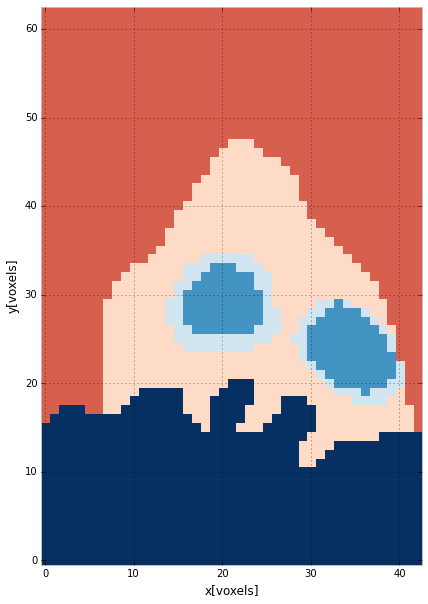

In [6]:
reload(geogrid)

G1.plot_section('z',cell_pos= 30,colorbar = False,  cmap='RdBu',
                figsize=(12.5,10),interpolation= 'nearest' ,ve = 1, contour =False,geomod_coord= False, savefig = True)

In [7]:
#G1.write_noddy_files()

G1.analyse_geophysics()
#G1.geophys.grv_data

### Creating the Bayesian Model of the input data!
#### First: Importing the uncertainty data from geolgical observations


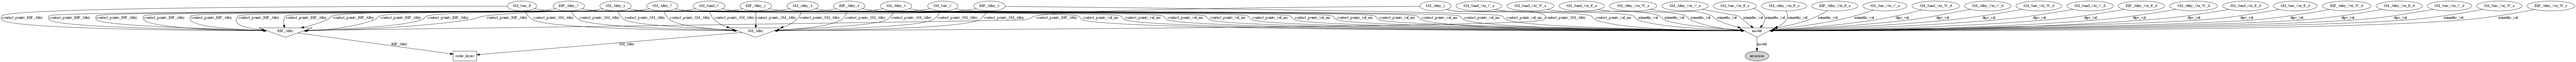

In [2]:
Image("Sandstone_inv.png")

In [3]:
data = pn.read_excel("C:\Users\Miguel\workspace\geobayes\paper_sandstone\models\Uncertainties.xlsx")                    
data_ar = data.values[:,[0,3,6,7]]
#print np.asarray(data_ar[data_ar[:,1] == "depth"][:,[0,2,3]])

#### Second: Importing Geophysic data

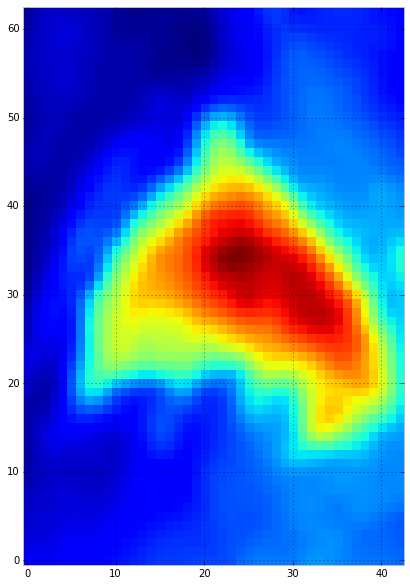

In [4]:
Sst_grav_1000 = np.loadtxt('Temp_Sandstone\Sandstone_geophys\Sst_grav_1000.xyz')
Sst_grav_2000 = np.loadtxt('Temp_Sandstone\Sandstone_geophys\Sst_grav_2000.xyz')
Sst_grav_500 = np.loadtxt('Temp_Sandstone\Sandstone_geophys\Sst_grav_500.xyz')

Grav_1000 = Sst_grav_1000[:,3].reshape((63,43))
#Grav_1000_norm = Grav_1000/np.min(Grav_1000)
Grav_1000_norm = (Grav_1000-np.max(Grav_1000))/np.min(Grav_1000-np.max(Grav_1000))
#print Sst_grav_1000[:,3].reshape((63,43))

plt.imshow(Grav_1000_norm, origin = "lower left",
       interpolation = 'nearest', cmap = 'jet_r')

## Creating out PyMC model our of this


In the first try we are gonna take the surface points as real values since in any case they will have less uncertainty.

In [35]:
#==============================
# Stochastics: Our input data
#============================
data_depth = np.asarray(data_ar[data_ar[:,1] == "depth"][:,[0, 2,3]])
contact_points_mc = []
for i in range(len(data_depth)):
    contact_points_mc = np.append(contact_points_mc, pm.Normal(str(data_depth[i,0]), data_depth[i,1], 1./np.square(data_depth[i,2])))
"""
data_azimuth = np.asarray(data_ar[data_ar[:,1] == "azimuth"][:,[0, 2,3]])
azimuths_mc = []    
for i in range(len(data_azimuth)):
    azimuths_mc = np.append(azimuths_mc, pm.Normal(str(data_azimuth[i,0]), data_azimuth[i,1], 1./np.square(data_azimuth[i,2])))   

data_dip = np.asarray(data_ar[data_ar[:,1] == "dip"][:,[0, 2,3]])
dips_mc = []
for i in range(len(data_dip)):
    dips_mc = np.append(dips_mc, pm.Normal(str(data_dip[i,0]), data_dip[i,1], 1./np.square(data_dip[i,2])))  
"""


#===============================
# First Constrains: Input data
#=============================
@pm.deterministic
def SM_Atley(contact_points_SM_Atley = contact_points_mc):
    SM_Atley = contact_points_mc[[int(np.argwhere(data_depth[:,0]=="SM_Atley_2")),int(np.argwhere(data_depth[:,0]=="SM_Atley_3")),
                              int(np.argwhere(data_depth[:,0]=="SM_Atley_4")),int(np.argwhere(data_depth[:,0]=="SM_Atley_5"))]]
    return SM_Atley
@pm.deterministic
def BIF_Atley(contact_points_BIF_Atley = contact_points_mc):
    BIF_Atley = contact_points_mc[[int(np.argwhere(data_depth[:,0]=="BIF_Atley_2")),int(np.argwhere(data_depth[:,0]=="BIF_Atley_3")),
                                  int(np.argwhere(data_depth[:,0]=="BIF_Atley_4")),int(np.argwhere(data_depth[:,0]=="BIF_Atley_5"))]]
    return BIF_Atley


@pm.potential
def order_layers(SM_Atley = SM_Atley, BIF_Atley = BIF_Atley):
    Atley_dif_1 = SM_Atley - BIF_Atley
   # print "dif", Atley_dif_1[:][:]
  #  if np.amin(Atley_dif_1) < 500:
  #      return -1
   # if np.amin(Atley_dif_1) < 0:
    #    return -2
    return 0
   
# ===============================================================================
# Generation of model
# ===============================================================================
@pm.deterministic
def model(contact_points_val = contact_points_mc):#, azimuths_val = azimuths_mc , dips_val = dips_mc):
# IMPORTANT NOTE: To be sure that the point we want to change fit with the Observation ID, I use the distribution name that
# in this case is in contact_points(parent values). Children values (contact_points_val) only have the number itself
    
    #print "contact_points_mc", contact_points_mc, contact_points_mc[0].value
    #print "caontact points val_mc", contact_points_val_mc[0]
   
  
    # Create the array we will use to modify the xml. We have to check the order of the formations
    
    global contact_points_mc
 #   global azimuths_mc
  #  global dips_mc
    contact_points_for_change = []
    azimuths_for_change = []
    dips_for_change = []
    for e, i in enumerate(contact_points_mc):
        contact_points_for_change.append([str(i), contact_points_val[e]])
 #   for e, i in enumerate(azimuths_mc):
  #      azimuths_for_change.append([str(i), azimuths_val[e]])
   # for e, i in enumerate(dips_mc):
    #    dips_for_change.append([str(i), dips_val[e]])    
    print contact_points_for_change
        
    
        #==================================================
        # Loading old model
        #==============================================
    # Load the xml to be modify
    org_xml = 'Temp_Sandstone/SanstoneSimple.xml'
    
    #Create the instance to modify the xml
        # Loading stuff
    reload(gxml) 
    gmod_obj = gxml.GeomodellerClass()
    gmod_obj.load_geomodeller_file(org_xml)

    
        #============================================
        # Modifing the model
        #===========================================
    gmod_obj.change_formation_values_PyMC(contact_points_mc = contact_points_for_change,
                                         azimuths_mc = azimuths_for_change,
                                         dips_mc = dips_for_change)
    
 
    
        #==============================================
        # wtiting new model
        #============================================

    # Write the new xml
    gmod_obj.write_xml("Temp_Sandstone/new.xml")
       
    # Read the new xml
    new_xml = 'Temp_Sandstone/new.xml'
    G1 = geogrid.GeoGrid()
    
    # Getting dimensions and definning grid
    G1.get_dimensions_from_geomodeller_xml_project(new_xml)
    G1.set_dimensions(dim=(705000,747000,6863000,6925000,-9272,1000))
    
    
    # Resolution!
    nx = 43
    ny = 63
    nz = 40
    G1.define_regular_grid(nx,ny,nz)
    
    # Updating project
    G1.update_from_geomodeller_project(new_xml)
#    G1.plot_section('x',cell_pos=23,colorbar = True,  alpha = 0.8, cmap = 'coolwarm_r',
 #                  figsize=(6,6),interpolation= 'nearest' ,ve = 1, geomod_coord= True, contour = False, 
  #                 savefig = False, fig_filename = "Uncertainty Sandstone")
    
    # Geophysics
    G1.analyse_geophysics()
    
    return G1


#================================
# Second Constrains: Interpolation
#===============================




#=================================
# Inversion
#=================================

@pm.deterministic
def e_sq(value = Grav_1000_norm,model = model):
    Forw = model.geophys.grv_data
    Forw_norm = (Forw-np.max(Forw))/np.min(Forw-np.max(Forw))
    e_sq = np.square(np.sum(value - Forw_norm))
    return e_sq


@pm.stochastic(observed = True)
def inversion(value = Grav_1000_norm, model = model):
    
    """
    print "distance", value - Forw_norm
    print "value", value
    print "Forw_norm", Forw_norm
    print "max,min", np.max(value),np.min(value), np.max(Forw_norm), np.min(Forw_norm)
    print e_sq
    
    print e_sq
    
    # 200000 is the tuned value
    try:
        counter += 1
        e_sq.append(e_sq)
    except UnboundLocalError:
        counter = 0
        e_sq 
    """    
    Forw = model.geophys.grv_data
    Forw_norm = (Forw-np.max(Forw))/np.min(Forw-np.max(Forw))
    e_sq = np.square(np.sum(value - Forw_norm))    
    print e_sq, (pm.half_cauchy_like(e_sq/180000,0.8,1)-pm.half_cauchy_like(0.8,0.8,1)), \
     10**(pm.half_cauchy_like(e_sq/180000,0.8,1)-pm.half_cauchy_like(0.8,0.8,1))
    return (pm.half_cauchy_like(e_sq/180000,0.8,1)-pm.half_cauchy_like(0.8,0.8,1))
   

#===========================================================00
#===========================================================
#CREATING THE MODEL
#==========================================================
#=========================================================

# Chaining the arrays
parameters = list(chain(contact_points_mc))#,dips_mc,azimuths_mc))

# Appending the rest
parameters.append(model)
#parameters.append(BIF_Atley)
#parameters.append(SM_Atley)
#parameters.append(order_layers)

parameters.append(e_sq)
parameters.append(inversion)

#print np.shape(parameters), parameters

pymc_model = pm.Model(parameters)

[['SM_Seis_C', array(6339.294162126513)], ['SM_Seis_E', array(3078.522218033279)], ['SM_Sand_C', array(4965.026176469971)], ['SM_Atley_1', array(4429.366933350987)], ['SM_Atley_2', array(3593.0914390662624)], ['SM_Atley_3', array(5952.288812508179)], ['SM_Atley_4', array(3130.897236810659)], ['SM_Atley_5', array(5656.024335009428)], ['BIF_Atley_2', array(1704.6660420755777)], ['BIF_Atley_3', array(3817.5282974090633)], ['BIF_Atley_4', array(560.1136148213409)], ['BIF_Atley_5', array(1608.8075913763896)]]
233605.382366 -0.221392007121 0.600631345008


In [10]:
parameters

[<pymc.distributions.Normal 'SM_Seis_C' at 0x000000001B55C5C0>,
 <pymc.distributions.Normal 'SM_Seis_E' at 0x00000000038F1780>,
 <pymc.distributions.Normal 'SM_Sand_C' at 0x00000000038F1908>,
 <pymc.distributions.Normal 'SM_Atley_1' at 0x000000001B55C5F8>,
 <pymc.distributions.Normal 'SM_Atley_2' at 0x000000001B55C630>,
 <pymc.distributions.Normal 'SM_Atley_3' at 0x000000001B55C668>,
 <pymc.distributions.Normal 'SM_Atley_4' at 0x000000001B55C6A0>,
 <pymc.distributions.Normal 'SM_Atley_5' at 0x00000000038F1CC0>,
 <pymc.distributions.Normal 'BIF_Atley_2' at 0x00000000038F14E0>,
 <pymc.distributions.Normal 'BIF_Atley_3' at 0x000000001B55C6D8>,
 <pymc.distributions.Normal 'BIF_Atley_4' at 0x000000001B55C710>,
 <pymc.distributions.Normal 'BIF_Atley_5' at 0x000000001B55C748>,
 <pymc.PyMCObjects.Deterministic 'model' at 0x000000001B55C780>,
 <pymc.PyMCObjects.Deterministic 'e_sq' at 0x000000001B55C898>,
 <pymc.PyMCObjects.Stochastic 'inversion' at 0x000000001B7880B8>]

In [22]:
a = gr.dag(pymc_model)
a.write_png("Sandstone_grav_Inv_test.png")

True

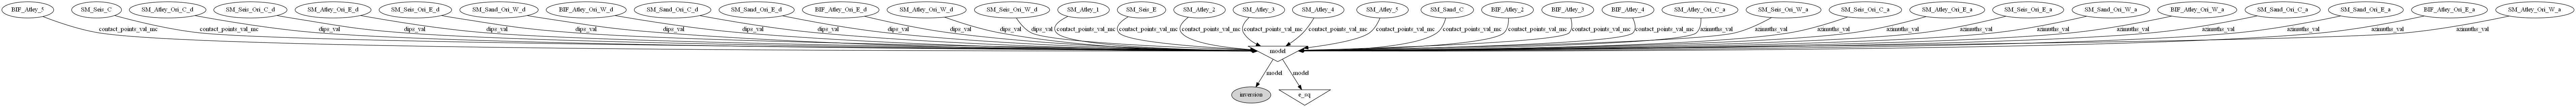

In [10]:
Image("Sandstone_grav_Inv_test.png")

In [36]:
S = pm.MCMC(pymc_model,  db= "hdf5" , dbname= "database_sands/Sandstone_inv13.hdf5")
#S.use_step_method(pm.AdaptiveMetropolis, parameters)


In [37]:
#S.restore_sampler_state
S.sample(iter=9)
S.db.close()

[['SM_Seis_C', array(6339.294162126513)], ['SM_Seis_E', array(3078.522218033279)], ['SM_Sand_C', array(4965.026176469971)], ['SM_Atley_1', array(4429.366933350987)], ['SM_Atley_2', array(3593.0914390662624)], ['SM_Atley_3', array(6483.41585060377)], ['SM_Atley_4', array(3130.897236810659)], ['SM_Atley_5', array(5656.024335009428)], ['BIF_Atley_2', array(1704.6660420755777)], ['BIF_Atley_3', array(3817.5282974090633)], ['BIF_Atley_4', array(560.1136148213409)], ['BIF_Atley_5', array(1608.8075913763896)]]
233605.382366 -0.221392007121 0.600631345008
[['SM_Seis_C', array(6339.294162126513)], ['SM_Seis_E', array(3078.522218033279)], ['SM_Sand_C', array(3845.920289505317)], ['SM_Atley_1', array(4429.366933350987)], ['SM_Atley_2', array(3593.0914390662624)], ['SM_Atley_3', array(5952.288812508179)], ['SM_Atley_4', array(3130.897236810659)], ['SM_Atley_5', array(5656.024335009428)], ['BIF_Atley_2', array(1704.6660420755777)], ['BIF_Atley_3', array(3817.5282974090633)], ['BIF_Atley_4', array(5

### Showing Results

In [16]:
#Loading data base
M = pm.database.hdf5.load("database_sands/Sandstone_inv13.hdf5")
M.chains

2

In [21]:
n_samples = 9

GeoMod_samples, GeoMod_samples_all = M.trace('model')[-n_samples:], M.trace('model')[:]


In [26]:
M.trace_names

[['BIF_Atley_2',
  'BIF_Atley_3',
  'BIF_Atley_4',
  'BIF_Atley_5',
  'Metropolis_BIF_Atley_2_adaptive_scale_factor',
  'Metropolis_BIF_Atley_3_adaptive_scale_factor',
  'Metropolis_BIF_Atley_4_adaptive_scale_factor',
  'Metropolis_BIF_Atley_5_adaptive_scale_factor',
  'Metropolis_SM_Atley_1_adaptive_scale_factor',
  'Metropolis_SM_Atley_2_adaptive_scale_factor',
  'Metropolis_SM_Atley_3_adaptive_scale_factor',
  'Metropolis_SM_Atley_4_adaptive_scale_factor',
  'Metropolis_SM_Atley_5_adaptive_scale_factor',
  'Metropolis_SM_Sand_C_adaptive_scale_factor',
  'Metropolis_SM_Seis_C_adaptive_scale_factor',
  'Metropolis_SM_Seis_E_adaptive_scale_factor',
  'SM_Atley_1',
  'SM_Atley_2',
  'SM_Atley_3',
  'SM_Atley_4',
  'SM_Atley_5',
  'SM_Sand_C',
  'SM_Seis_C',
  'SM_Seis_E',
  'deviance',
  'e_sq',
  'model'],
 ['BIF_Atley_2',
  'BIF_Atley_3',
  'BIF_Atley_4',
  'BIF_Atley_5',
  'Metropolis_BIF_Atley_2_adaptive_scale_factor',
  'Metropolis_BIF_Atley_3_adaptive_scale_factor',
  'Metropolis_

### Plotting: Representation of the Models

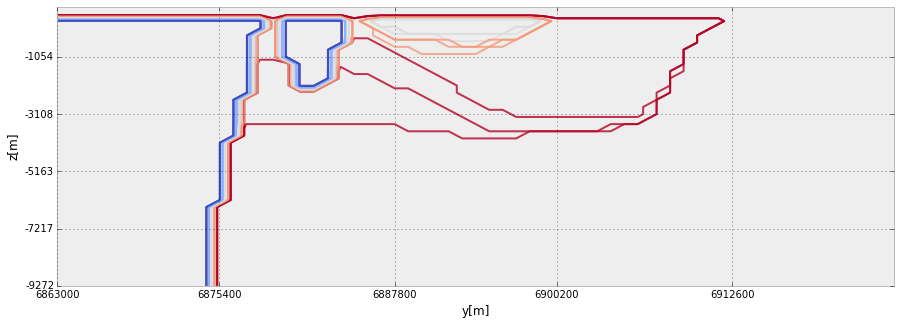

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

figsize(12.5, 10)

for i in GeoMod_samples:
    i.plot_section('x',cell_pos=23,colorbar = True, ax = ax, alpha = 0.8, cmap = 'coolwarm_r',
                   figsize=(6,6),interpolation= 'nearest' ,ve = 1, geomod_coord= True, contour = True, 
                   savefig = True, fig_filename = "Uncertainty Sandstone")
    

C:\Users\Miguel\Anaconda\lib\site-packages\matplotlib\axes\_base.py:1057: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
C:\Users\Miguel\Anaconda\lib\site-packages\matplotlib\axes\_base.py:1062: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


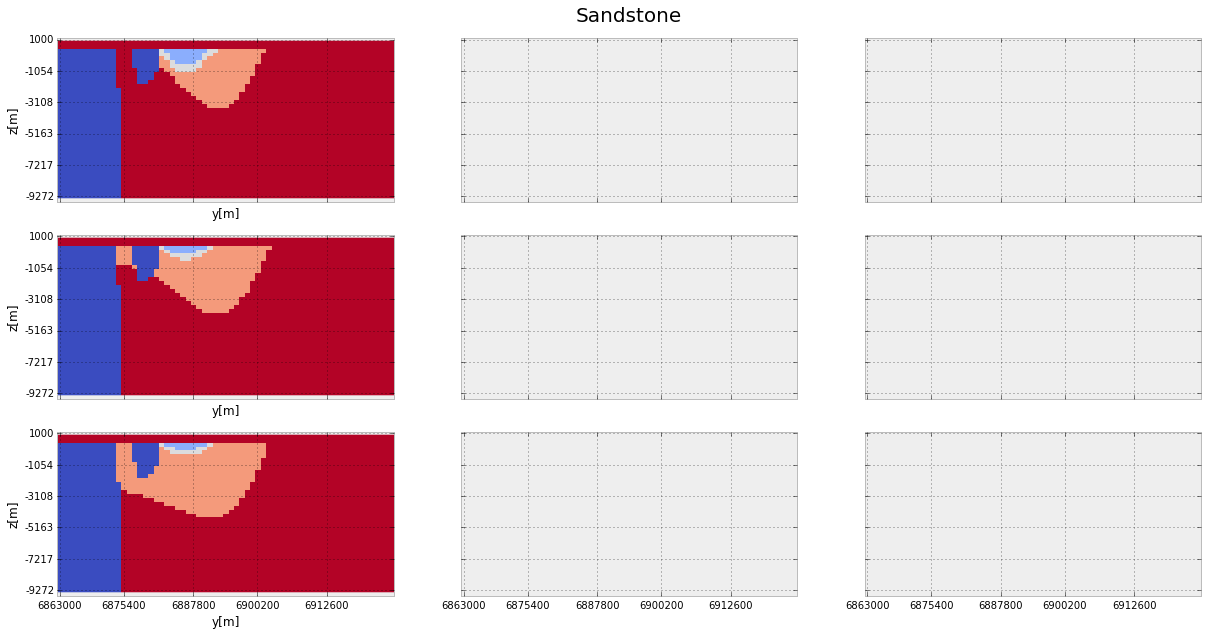

In [23]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize = (20.5, 10))


plt.text(0.5, 1.1, "Sandstone",
     horizontalalignment='center',
        fontsize=20,
        transform = axs[0,1].transAxes)
#plt.subplots_adjust(top=2.15)
#axs[0,1].set_title("Posterior Faults: Non-Constrains", fontsize=20)

for i, g  in enumerate(GeoMod_samples):
    g.plot_section('x',cell_pos=30,colorbar = True, cmap = "coolwarm_r", fig_filename = "9plots",
                   ax = axs[i- 3*(i/3),i/3], alpha = 1, figsize= (50,6),interpolation= 'nearest' ,
                   ve = 3, geomod_coord= True, contour = False)    
    
plt.savefig("9plot_grav_noInv.png", transparent = True)    

### Plotting: Gravity

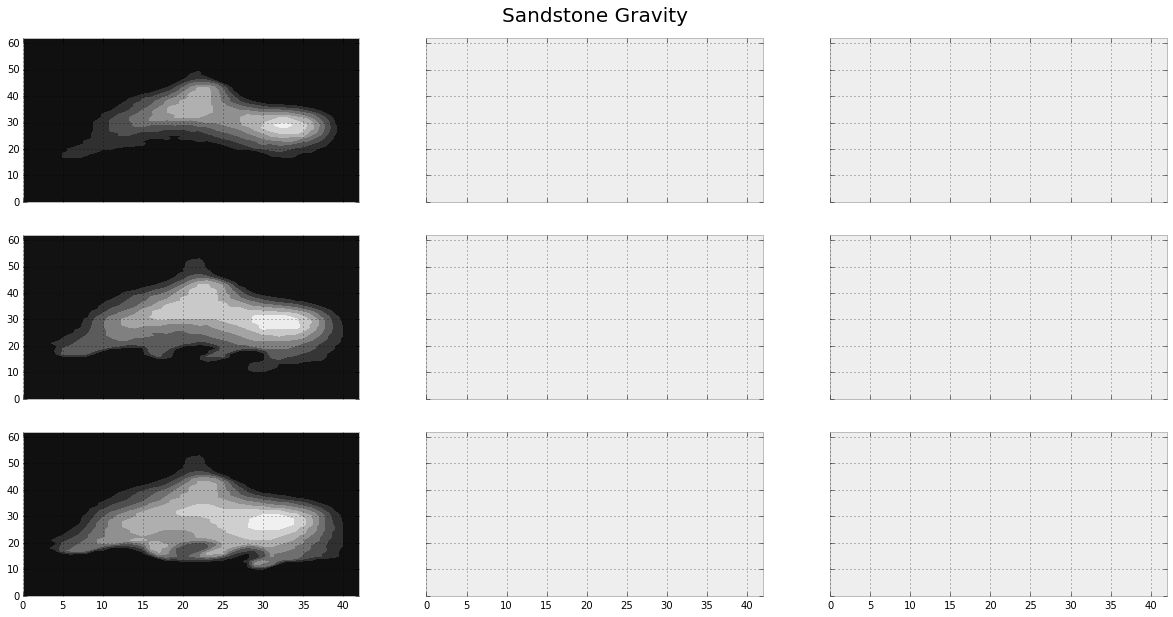

In [24]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize = (20.5, 10))


plt.text(0.5, 1.1, "Sandstone Gravity",
     horizontalalignment='center',
        fontsize=20,
        transform = axs[0,1].transAxes)
#plt.subplots_adjust(top=2.15)
#axs[0,1].set_title("Posterior Faults: Non-Constrains", fontsize=20)

for i, g  in enumerate(GeoMod_samples):
    cf = axs[i- 3*(i/3),i/3].contourf(g.geophys.grv_data, cmap = 'gray' , alpha = 1, figsize= (50,6))
    
    
plt.savefig("9plot_grav_no_inv.png", transparent = True)    

In [25]:
M.trace("e_sq")[:]

array([ 321394.11979574,  235763.38847906,  163081.44366514])

(59.526460999999998, 59.494371999999998)

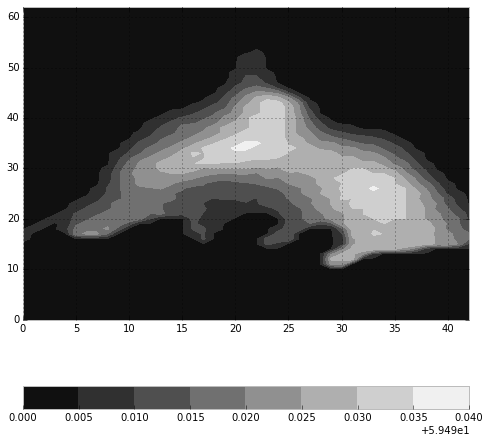

In [26]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)
# imshow(geophys.grv_data, cmap = 'jet')
# define contour levels
levels = np.arange(322,344,1)
n = 0
cf = ax.contourf(GeoMod_samples[n].geophys.grv_data, cmap = 'gray')#, vmin = 324, vmax = 342)
cbar = plt.colorbar(cf, orientation = 'horizontal')
# print levels
np.max(GeoMod_samples[n].geophys.grv_data), np.min(GeoMod_samples[n].geophys.grv_data)

In [ ]:
for i in range(9):
    print M.trace("e_sq")[i]

### Entrophy representation

In [ ]:
import copy

In [ ]:
%matplotlib inline

In [ ]:
pid = 1

#p5 = np.zeros_like(section_samples[0].grid)
p5 = copy.deepcopy(section_samples[0])
p5.grid = np.zeros_like(section_samples[0].grid)
                       
for i in range(9):
    p5.grid += section_samples[i].grid == pid 


In [ ]:
# p5.grid = p5.grid / 9.
print (type(p5.grid))
a = np.array_like(p5.grid)
print a, type(a)
p5.grid.dtype = np.float64

p5.grid = p5.grid / 2.

p5.plot_section('x',cell_pos=40,colorbar = True, alpha = 0.8, cmap = 'coolwarm_r',
                   figsize=(6,6),interpolation= 'nearest' ,ve = 1, geomod_coord= True, contour = False, 
                   savefig = True, fig_filename = "Uncertainty Sandstone")
    

In [ ]:
H = -sum pi log pi

In [ ]:
plot(M);


# Appendix

## Setting likelihood function of our square error
#### Original distribution of the data set

In [ ]:
np.std([338670.089523,
338670.089523,
341149.691432,
338250.817324,
338250.817324,
347225.463374,
338250.817324,
342836.015403,
359912.15874,
337015.485315,
331324.439088,
339086.301635,
434971.767717,
380665.374131,
366915.207353,
339982.899655,
355394.292478,
338250.817324,
330984.624601,
346300.339349,
338090.806503,
269010.561144,
335858.649065,
354252.093153,
639530.463419,
327690.002776,
485602.293459,
327690.002776,
452187.547702,
327547.64648,
335356.231036,
347516.800244,
546931.270467,508781.785886,
483825.523836,
483825.523836,
653584.638967,
446093.548236,
441425.68478,
449149.63845,
473617.175573,
446093.548236,
476889.432333,
479666.645621,
445250.308845,
446176.479658,
446093.548236,
566054.643212,
457627.506278,
442201.6842,
432693.469404,
446093.548236,
487942.462445,
447527.003265,
446077.904606,
654540.510933,
445311.83028,
445795.869931,
607805.64506,
432593.648497,
388386.392707,
432593.648497,
431968.623763,
431692.211434,
434875.871853,
432593.648497,
327048.370021])

In [ ]:
import scipy.stats as stats
stats.halfcauchy?

In [43]:
f = pm.normal_like(10,3,0.1)
10**f

3.0183452898610984e-05

In [ ]:
x = np.linspace(0,5,100)
print pm.half_cauchy_like(1,1,2)
a = [10**(pm.half_cauchy_like(i,0.8,2.5)-pm.half_cauchy_like(0.8,0.8,2.5)) for i in x]
b = stats.halfcauchy
#c = [10**b.logcdf(i,scale = -3) for i in x]
plt.plot(x, a)
plt.plot(x,c)                        

In [ ]:
stats.alpha?

In [ ]:
x = np.linspace(0,100)
c = stats.alpha

plt.plot(x, c.pdf(x, .1,6))

In [ ]:
e = pm.Exponential("e_rr",4.)
c = stats.exponweib
#print c.logcdf(10,scale = 100000)
samples = [e(i/10000) for i in range(100000)]
plt.hist(samples, bins=70, normed=True, histtype="stepfilled")

In [ ]:
e = pm.Normal("e_rr",417063.72914102982, 1./np.square(44298.551876983955))
samples = [e.random() for i in range(20000)]
plt.hist(samples, bins=70, normed=True, histtype="stepfilled")

In [ ]:
e = pm.Normal("e_rr", 317255.22037079412, 1./np.square(58662.459836067414))
samples = [e.random() for i in range(20000)]
plt.hist(samples, bins=70, normed=True, histtype="stepfilled")

#### Filtered

Here you can decide how much value you give to your Inversion

In [ ]:
e = pm.Normal("e_rr", 317255.22037079412, 1./np.square(25000))
samples = [e.random() for i in range(20000)]
plt.hist(samples, bins=70, normed=True, histtype="stepfilled")

## Visualization of the parameters that change in every iteration

### Info values in original xml

In [ ]:
reload(gxml)
gmod_obj = gxml.GeomodellerClass()
gmod_obj.load_geomodeller_file(sandstone)

gmod_obj.change_formation_values_PyMC(info = True)

### Info values in changed xml

In [ ]:
reload(gxml)
gmod_obj = gxml.GeomodellerClass()
gmod_obj.load_geomodeller_file( 'Temp_Sandstone/new.xml')
gmod_obj.change_formation_values_PyMC(info = True)

In [ ]:
# Section names:
section_names = gmod_obj.get_section_names()
print "section names",section_names, "\n" 

# Choose the section we want to use with Positon
sections = gmod_obj.get_sections()
print "Chosen section by position", sections, "\n"

# Create a dictionary so we can acces the section through the name
section_dict = gmod_obj.create_sections_dict()
print "Chosen section by entry", section_dict["Seismic"][1], "\n"



# Formation names
formation_names = gmod_obj.get_formation_names()
print "formation names", formation_names, "\n"

# Get the points of all formation for a given section: Position
#contact_points = gmod_obj.get_formation_point_data(sections) #to extract points you have to choose one of the sections
#print "Contact points on the chosen section", contact_points, "\n", type(contact_points)

## Get the points of all formation for a given section: Dictionary
contact_points = gmod_obj.get_formation_point_data(section_dict['Atley']) #to extract points you have to choose one of the sections
print "Contact points on the chosen section", contact_points, "\n", type(contact_points), np.shape(contact_points)

# Showing contact points
points = gmod_obj.get_point_coordinates(contact_points)
print "Points coordinates\n", points, np.shape(points), "\n"

# Foliations

foliations = gmod_obj.get_foliations(section_dict['Atley'])
print "foliations" , foliations,  "\n\n\n"
for i in range(len(foliations)): print "azimut:",gmod_obj.get_foliation_azimuth(foliations[i]), "dip",gmod_obj.get_foliation_dip(foliations[i]), "coordinates", gmod_obj.get_foliation_coordinates(foliations[i])  


In [ ]:
`piy  zx cvm

In [ ]:

ZXDEW1ÇohyrwsQWET UO`<   -1